<ipython-input-21-eb69146f29a1>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_rate_by_hour.index, y=fraud_rate_by_hour.values, palette="rocket")


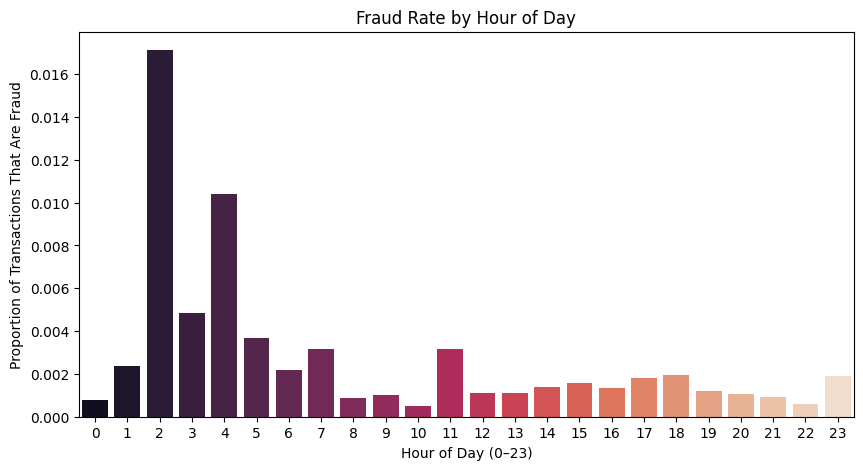

Highest fraud rate at Hour = 2:00 → 1.71% of transactions fraudulent.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the data
data = pd.read_csv("creditcard.csv")

# 2. Compute the hour of day for each transaction
#Time seconds me tha so convert
data["Hour"] = ((data["Time"] // 3600) % 24).astype(int)

# 3. Cyclical encoding
data["Hour_sin"] = np.sin(2 * np.pi * data["Hour"] / 24)
data["Hour_cos"] = np.cos(2 * np.pi * data["Hour"] / 24)

# 4. Exploratory: fraud rate by hour of day
fraud_rate_by_hour = data.groupby("Hour")["Class"].mean()  # fraction of transactions that are fraud

# 5. Plot fraud rate
plt.figure(figsize=(10, 5))
sns.barplot(x=fraud_rate_by_hour.index, y=fraud_rate_by_hour.values, palette="rocket")
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Proportion of Transactions That Are Fraud")
plt.xticks(range(24))
plt.show()

# 6. The hour with the highest fraud rate
peak_hour = fraud_rate_by_hour.idxmax()
peak_rate = fraud_rate_by_hour.max()
print(f"Highest fraud rate at Hour = {peak_hour}:00 → {peak_rate:.2%} of transactions fraudulent.")


In [ ]:
import cudf, cupy as cp
import pandas as pd
import numpy as np
from cuml.preprocessing import StandardScaler as cuStandardScaler
from cuml.decomposition import PCA as cuPCA
from cuml.neighbors import KNeighborsClassifier as cuKNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             f1_score, recall_score, precision_score,
                             accuracy_score)
from imblearn.over_sampling import SMOTE

#LOAD & PREP DATA
df = pd.read_csv("creditcard.csv").dropna(subset=["Class"])
df["Amount_scaled"] = (df["Amount"] - df["Amount"].mean()) / df["Amount"].std()

features = [c for c in df.columns if c.startswith("V")] + ["Amount_scaled"]
X = df[features]
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# SMOTE
X_tr_res, y_tr_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

# B. MOVE TO GPU
gdf_train = cudf.DataFrame.from_pandas(X_tr_res)
gdf_y     = cudf.Series(y_tr_res.values)
gdf_test  = cudf.DataFrame.from_pandas(X_test)

# C. PCA to KNN (uniform weights)
from cuml.neighbors import KNeighborsClassifier as cuKNN

# 1. Scale (pehle jaisa)
scaler = cuStandardScaler()
gX_train_s = scaler.fit_transform(gdf_train)
gX_test_s  = scaler.transform(gdf_test)

# 2. PCA (We are taking 20 components)
pca = cuPCA(n_components=20, random_state=42)
gX_train_p = pca.fit_transform(gX_train_s)
gX_test_p  = pca.transform(gX_test_s)

# 3. KNN with uniform voting
knn = cuKNN(n_neighbors=7, weights="uniform", p=2)
knn.fit(gX_train_p, gdf_y)

# D. PREDICT & METRICS
proba_gpu = knn.predict_proba(gX_test_p).to_pandas().values[:,1]
preds     = (proba_gpu >= 0.5).astype(int)

# Here we are computing metrics
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    f1_score, recall_score, precision_score, accuracy_score
)
import numpy as np

metrics = {
    "AUC":        roc_auc_score(y_test, proba_gpu),
    "PRAUC":      average_precision_score(y_test, proba_gpu),
    "F1":         f1_score(y_test, preds),
    "Recall":     recall_score(y_test, preds),
    "Precision":  precision_score(y_test, preds),
    "Accuracy":   accuracy_score(y_test, preds),
}
# KS
pos = np.sort(proba_gpu[y_test==1])
neg = np.sort(proba_gpu[y_test==0])
grid = np.linspace(0,1,100)
cdf_pos = np.searchsorted(pos, grid, side="right") / len(pos)
cdf_neg = np.searchsorted(neg, grid, side="right") / len(neg)
metrics["KS"] = float(np.max(np.abs(cdf_pos - cdf_neg)))

for k,v in metrics.items():
    print(f"  {k:10s}: {v:.4f}")

[2025-04-18 09:18:07.169] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization
  AUC       : 0.9074
  PRAUC     : 0.4223
  F1        : 0.3833
  Recall    : 0.7770
  Precision : 0.2544
  Accuracy  : 0.9957
  KS        : 0.8106


In [ ]:
import pandas as pd
import numpy as np

import cudf
import cupy as cp
from cuml.preprocessing import StandardScaler as cuScaler
from cuml.decomposition import PCA as cuPCA
from cuml.neighbors import KNeighborsClassifier as cuKNN
from cuml.linear_model import LogisticRegression as cuLogReg

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    f1_score, recall_score, precision_score,
    accuracy_score
)

# Load Data
data = pd.read_csv("creditcard.csv", low_memory=False)
data = data.dropna(subset=["Class"])
data["Class"] = data["Class"].astype(int)

# Scale Amount
from sklearn.preprocessing import StandardScaler
data["Amount_scaled"] = StandardScaler().fit_transform(data[["Amount"]])

features = [c for c in data.columns if c.startswith("V")] + ["Amount_scaled"]
X = data[features]
y = data["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# SMOTE
X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Convert to cuDF (GPU WALA PART)
gX_train = cudf.DataFrame.from_pandas(X_train_res)
gy_train = cudf.Series(y_train_res.values)
gX_test  = cudf.DataFrame.from_pandas(X_test)

#Standard Scaling and PCA
scaler = cuScaler()
gX_train_s = scaler.fit_transform(gX_train)
gX_test_s  = scaler.transform(gX_test)

pca = cuPCA(n_components=15)
gX_train_p = pca.fit_transform(gX_train_s)
gX_test_p  = pca.transform(gX_test_s)

# KNN
knn = cuKNN(n_neighbors=9)
knn.fit(gX_train_p, gy_train)
knn_pred_proba = knn.predict_proba(gX_test_p).to_pandas().values[:, 1]

# XGBoost
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="gpu_hist",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)
xgb.fit(X_train_res, y_train_res)
xgb_pred_proba = xgb.predict_proba(X_test)[:, 1]

# LightGBM (CPU)
lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=8,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm.fit(X_train_res, y_train_res)
lgbm_pred_proba = lgbm.predict_proba(X_test)[:, 1]

# Meta-Model (Logistic Regression) with OOF Predictions
meta_input = np.vstack([
    knn_pred_proba,
    xgb_pred_proba,
    lgbm_pred_proba
]).T

g_meta_X = cudf.DataFrame(meta_input)
g_meta_y = cudf.Series(y_test.values)

meta = cuLogReg()
meta.fit(g_meta_X, g_meta_y)
meta_pred_proba = meta.predict_proba(g_meta_X).to_pandas().values[:, 1]
meta_pred_class = (meta_pred_proba >= 0.5).astype(int)

# Metrics
def ks_stat(y_true, y_pred_proba):
    pos = np.sort(y_pred_proba[y_true == 1])
    neg = np.sort(y_pred_proba[y_true == 0])
    grid = np.linspace(0, 1, 100)
    cdf_pos = np.searchsorted(pos, grid, side="right") / len(pos)
    cdf_neg = np.searchsorted(neg, grid, side="right") / len(neg)
    return np.max(np.abs(cdf_pos - cdf_neg))

print(f"AUC:        {roc_auc_score(y_test, meta_pred_proba):.4f}")
print(f"PRAUC:      {average_precision_score(y_test, meta_pred_proba):.4f}")
print(f"F1 Score:   {f1_score(y_test, meta_pred_class):.4f}")
print(f"Recall:     {recall_score(y_test, meta_pred_class):.4f}")
print(f"Precision:  {precision_score(y_test, meta_pred_class):.4f}")
print(f"Accuracy:   {accuracy_score(y_test, meta_pred_class):.4f}")
print(f"KS Stat:    {ks_stat(y_test, meta_pred_proba):.4f}")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:18:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:18:17] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [09:18:19] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] Number of positive: 199020, number of negative: 199020
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.096977 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7395
[LightGBM] [Info] Number of data points in the train set: 398040, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
AUC:        0.9670
PRAUC:      0.8260
F1 Score:   0.8042
Recall:     0.7770
Precision:  0.8333
Accuracy:   0.9993
KS Stat:    0.8434
